In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
np.random.seed(0)
torch.manual_seed(0)

In [2]:
N = 1000
Q = 1
nb_output = 2  # total number of output
D1 = 1  # first output
D2 = 1  # second output

In [3]:
def gen_data(N):
    X = np.random.randn(N, Q)
    w1 = 2.
    b1 = 8.
    sigma1 = 1
    Y1 = X.dot(w1) + b1 + sigma1 * np.random.randn(N, D1)
    w2 = 3
    b2 = 3.
    sigma2 = 1
    Y2 = X.dot(w2) + b2 + sigma2 * np.random.randn(N, D2)
    return X, Y1, Y2

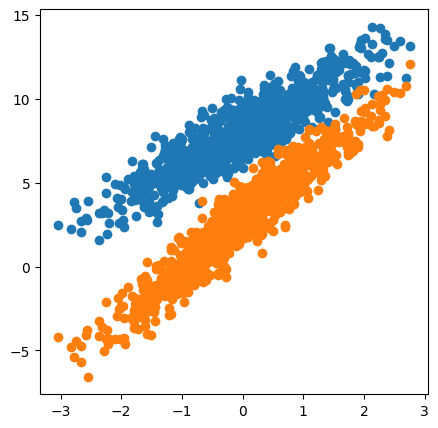

In [4]:
import pylab
%matplotlib inline

X, Y1, Y2 = gen_data(N)
pylab.figure(figsize=(5, 5))
pylab.scatter(X[:, 0], Y1[:, 0])
pylab.scatter(X[:, 0], Y2[:, 0])
pylab.show()

In [5]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output1_size, output2_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output1_size)
        self.fc3 = nn.Linear(hidden_size, output2_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out1 = self.fc2(out)
        out2 = self.fc3(out)
        return out1, out2

In [6]:
nb_features = 1024

In [7]:
model = Net(Q, nb_features, D1, D2)

In [8]:
l_multiplier = torch.zeros((1,), requires_grad=True)
epsilon = 0.5
damping = 10.0

In [9]:
loss_1 = nn.MSELoss()

In [10]:
loss_2 = nn.MSELoss()

In [11]:
def lagrangian(y_pred, y_true, l_multiplier):
    loss1 = loss_1(y_pred[0], y_true[0])
    loss2 = loss_2(y_pred[1], y_true[1])
    infeasibility = loss2 - epsilon
    damp = damping * (infeasibility**2 / 2)
    return loss1 + (l_multiplier * infeasibility) + damp

In [12]:
def linear_add(y_pred, y_true):
    loss1 = loss_1(y_pred[0], y_true[0])
    loss2 = loss_2(y_pred[1], y_true[1])
    return loss1 + loss2

In [13]:
optimizer_wt = optim.Adam(model.parameters(), lr=1e-3)
optimizer_l = optim.Adam([l_multiplier], lr=1e-3)

In [14]:
# convert data into torch from numpy array
X = X.astype('float32')
Y1 = Y1.astype('float32')
Y2 = Y2.astype('float32')

In [15]:
def shuffle_data(X,Y1,Y2):
    s = np.arange(X.shape[0])
    np.random.shuffle(s)
    return X[s], Y1[s], Y2[s]

In [16]:
epochs = 500
batch_size = 32

In [18]:
## Train Network
loss_history = np.zeros(epochs)

for i in range(epochs):

    epoch_loss = 0
    
    X, Y1, Y2 = shuffle_data(X, Y1, Y2)
    
    for j in range(N//batch_size):
        
        inp = torch.from_numpy(X[(j*batch_size):((j+1)*batch_size)])
        target1 = torch.from_numpy(Y1[(j*batch_size):((j+1)*batch_size)])
        target2 = torch.from_numpy(Y2[(j*batch_size):((j+1)*batch_size)])
        
        out = model(inp)
        
        optimizer_wt.zero_grad()
        optimizer_l.zero_grad()

        loss = lagrangian(out, [target1, target2], l_multiplier)
        epoch_loss += loss.item()

        loss.backward()
        for group in optimizer_l.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad = -1*p.grad

        optimizer_wt.step()
        optimizer_l.step()

        # optimizer_wt.zero_grad()

        # loss = linear_add(out, [target1, target2])
        # epoch_loss += loss.item()

        # loss.backward()
        # optimizer_wt.step()
   
    loss_history[i] = epoch_loss * batch_size / N

In [19]:
model.eval()
with torch.no_grad():
    inp = torch.from_numpy(X)
    target1 = torch.from_numpy(Y1)
    target2 = torch.from_numpy(Y2)
    out1, out2 = model(inp)
    print(loss_1(out1, target1).item())
    print(loss_2(out2, target2).item())
model.train()

0.9420067071914673
0.9017412066459656


Net(
  (fc1): Linear(in_features=1, out_features=1024, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
  (fc3): Linear(in_features=1024, out_features=1, bias=True)
)

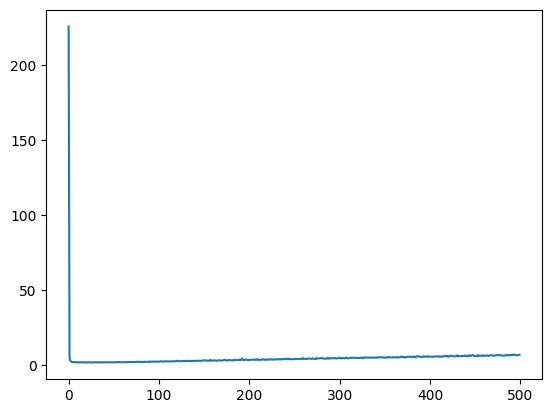

In [20]:
# plot loss history

pylab.plot(loss_history)